# Table of Contents

1. [Import stuff](#import_everything)
2. [Set whether these analyses are done for this analysis or not](#set_whether_these_analyses_are_done_for_this_analysis_or_not)
3. [Load data](#os.path.exists_checkpoint_fig_dir_load_data)
    1. [Set values for indexing](#Set_some_values_for_indexing_etc)
    2. [Rearranging data](#Rearranging_data)
4. [Start Analyses](#Start_Analyses)
6. [Correlation Analysis](#Correlation_AnalysisFirstsetupcorrelationmatricesforfinalepochineachtask)
    1. [Plot Within Pair Correlation Over Time](#Plot_Within_Pair_Correlation_Over_Time)
    2. [Is the low/med/high within pair correlation in the right order in the output layer?](#is_the_low/med/high_within_pair_correlation_in_the_right_order_in_the_output_layer?)
    3. [Is the low/med/high within pair correlation in the right order in the hidden layer?](#is_the_low/med/high_within_pair_correlation_in_the_right_order_in_the_hidden_layer?)
    4. [Before vs After correlation](#before_vs_after_correlation)
    5. [MDS](#MDS)
9. [Center of mass](#CENTER_OF_MASS)
12. [Add necessary checkpoint info](#Add_necessary_checkpoint_info)
13. [Save](#Save)



## Imports
<a id='import_everything'></a>

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from matplotlib.backends.backend_pdf import PdfPages
import os as os
import sys as sys
from collections import defaultdict
from sklearn.manifold import MDS


import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import traceback
import pprint
import cProfile, pstats, io
import traceback
from matplotlib.lines import Line2D

codeprofiler = cProfile.Profile()

pp = pprint.PrettyPrinter(indent=4)

idx = pd.IndexSlice

sns.set_style(style='white')
pd.set_option('display.max_columns', 30)


In [2]:
print('Number of arguments:', len(sys.argv), 'arguments.')
print('Argument List:', str(sys.argv))
print('---')
from_cmdLine = sys.argv[-1]
print(from_cmdLine)

print('---')


Number of arguments: 3 arguments.
Argument List: ['/usr/people/qanguyen/anaconda3/envs/leabra/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/mnt/cup/people/qanguyen/.local/share/jupyter/runtime/kernel-2e0e3f47-f025-4932-9bc0-57bc08cdd768.json']
---
/mnt/cup/people/qanguyen/.local/share/jupyter/runtime/kernel-2e0e3f47-f025-4932-9bc0-57bc08cdd768.json
---


In [3]:
if from_cmdLine == 'cmd' :
    data_file = sys.argv[-2]
    print('using command line to set data')
    dataDir = data_file + '/'
else :
    print('using script to set data')

    #Set the date of the data we want to look at:

    data_file = '2021-05-26-11-03-22' #2 runs
#     data_file = '2021-05-31-16-41-55' #same trial, 20 runs
#     data_file = '2021-05-31-16-46-29' #different trial, 20 runs

    data_file = 'same_diff2/Same/'
    
    data_file = '2021-10-31-11-37-45'
    data_file = '2021-10-31-12-03-00'
    data_file = '2021-11-22-18-55-43'
    data_file = '2022-06-09-12-41-26' # sample with just 3 runs
#     data_file = '2021-12-09-00-09-59'
    dataDir = 'data/' + data_file + '/'
    dataDir = '/scratch/qanguyen/favila/alex_may_25_2022/results_--same_diff_flag=Same/'

using script to set data


### set whether these analyses are done for this analysis or not
<a id='set_whether_these_analyses_are_done_for_this_analysis_or_not'></a>

In [4]:
test_trial_done = 1
train_trial_done = 1
test_cycle_done = 0
train_cycle_done = 0

#Do you want this code to spit out a good NMPH curve based on the activity? 
#For regular analyses, that code chunk should get skipped.
calculate_learning_curve = 0



# Load Data
<a id='os.path.exists_checkpoint_fig_dir_load_data'></a>

In [5]:

figDir = dataDir + 'fig/'
checkpoint_fig_dir = figDir + 'checkpoints/'
results_fig_dir = figDir + 'results/'
eps_dir = results_fig_dir + 'eps_files/'

if not os.path.exists(figDir) :
    os.mkdir(figDir)
    
if not os.path.exists(results_fig_dir) :
    os.mkdir(results_fig_dir)
    
if not os.path.exists(checkpoint_fig_dir) :
    os.mkdir(checkpoint_fig_dir)
    
if not os.path.exists(eps_dir) :
    os.mkdir(eps_dir)

if not os.path.exists(checkpoint_fig_dir + 'cycle_plots/') :
    os.mkdir(checkpoint_fig_dir + 'cycle_plots/')

In [6]:
# data_run = pd.read_csv(dataDir + 'output_diff_Base_run.csv', sep = '\t')
# print('max run: ' + str(data_run.iloc[-1]['|Run']))

# data_run.iloc[:,:]

In [7]:
# data_run["#Seed"].to_numpy().std()

In [8]:
codeprofiler.enable()

In [9]:
data_epc = pd.read_csv(dataDir + 'favila_Base_epc.csv', sep = '\t')
# data_epc

In [10]:
if (test_trial_done == 1) :
    print('loading test trial data')
    
    data_test = pd.read_csv(dataDir + 'favila_Base_tsttrl.csv', sep = '\t')
    data_test = data_test[data_test['|Run'] != '|Run'] ## because of error where header line is repeated. remove that one lne
    assert set(data_test['$TrialName']) == {'med1', 'med2'}, "Trial name must be either med1 or med2"
    print('done')
    
data_test[(data_test["|Epoch"] <1)]

loading test trial data
done


,|Run,|Epoch,$CurrentTask,$CurrentTest,|Trial,$TrialName,#Scene_Err,#Scene_SSE,#Scene_AvgSSE,#Scene_CosDiff,#Category_Err,#Category_SSE,#Category_AvgSSE,#Category_CosDiff,#Output_Err,...,"#OutActP[2:0,35]","#OutActP[2:0,36]","#OutActP[2:0,37]","#OutActP[2:0,38]","#OutActP[2:0,39]","#OutActP[2:0,40]","#OutActP[2:0,41]","#OutActP[2:0,42]","#OutActP[2:0,43]","#OutActP[2:0,44]","#OutActP[2:0,45]","#OutActP[2:0,46]","#OutActP[2:0,47]","#OutActP[2:0,48]","#OutActP[2:0,49]"
0,0,-1,TaskColorWOOsc,TestColorAll,0,med1,0,0,0,0.9989,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
1,0,-1,TaskColorWOOsc,TestColorAll,1,med2,0,0,0,0.9994,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
2,0,0,TaskColorRecall,TestColorAll,0,med1,0,0,0,0.9992,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
3,0,0,TaskColorRecall,TestColorAll,1,med2,0,0,0,1.0000,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
42,1,-1,TaskColorWOOsc,TestColorAll,0,med1,0,0,0,0.9993,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,48,0,TaskColorRecall,TestColorAll,1,med2,0,0,0,1.0000,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
2058,49,-1,TaskColorWOOsc,TestColorAll,0,med1,0,0,0,0.9993,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
2059,49,-1,TaskColorWOOsc,TestColorAll,1,med2,0,0,0,0.9997,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
2060,49,0,TaskColorRecall,TestColorAll,0,med1,0,0,0,0.9991,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45


In [11]:
def fill_dummy_stim(data_test, task_type) :
    
#     remaining_columns = [c for c in data_test.columns if c not in ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', '$TrialName']]
#     fake_data = data_test[data_test['$TrialName'] == 'med1'].reset_index(drop = True)

#     dummy_df = pd.DataFrame()
#     for loc in range(max(fake_data.index) + 1) : 
#         dummy_trial = 2
#         for trialType in ['low1','low2', 'high1', 'high2'] :
#             temp = fake_data.loc[[loc]]
#             temp[remaining_columns] = 0
#             temp['$TrialName'] = trialType
#             temp['|Trial'] = dummy_trial
#             dummy_trial += 1
#             dummy_df = dummy_df.append(temp)

#     dummy_df
    
#     data_test = data_test.append(dummy_df)
# #     return(data_test)


    if task_type == 'test' :
        first_columns = [c for c in data_test.columns if c in ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest']]
        remaining_columns = [c for c in data_test.columns if c not in ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', '|Trial', '$TrialName']]

    elif task_type == 'train':
        first_columns = [c for c in data_test.columns if c in ['|Run', '|Epoch', '$CurrentTask', ]]
        remaining_columns = [c for c in data_test.columns if c not in ['|Run', '|Epoch', '$CurrentTask', '|Trial', '$TrialName']]

    numeric_columns = [c for c in remaining_columns if c not in ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', '$TrialName']]
    ### DF 1:
    #make a df with the columns that we want to be not-zero for our dummy values
    df_1 = data_test[first_columns].drop_duplicates()

    #add a dummy column so that we can do an outer merge later
    df_1['dummy'] = 1
    
    ### DF2 :
    #make a second df with just the trial number, trial names, and all the columns that will be zero
    df_2 = pd.DataFrame(columns = remaining_columns)
    
    #add the rows taht are zeroed out for each of our fake stimuli
    df_2 = df_2.append(pd.Series(0, index=df_2.columns), ignore_index=True)
    df_2 = df_2.append(pd.Series(0, index=df_2.columns), ignore_index=True)
    df_2 = df_2.append(pd.Series(0, index=df_2.columns), ignore_index=True)
    df_2 = df_2.append(pd.Series(0, index=df_2.columns), ignore_index=True)


    #add in a column with the values of each stim. This df now has 4 rows (one for each of our fake stim)
    df_2.insert(0, "$TrialName", ['low1','low2','high1','high2'], False) 
    df_2.insert(0, "|Trial", [2,3,4,5], False) 
    
    #add a dummy column so that we can do an outer merge
    df_2['dummy'] = 1
    df_2[numeric_columns] = df_2[numeric_columns].apply(pd.to_numeric)
    #do an outer merge of the two dfs. This is everything we need for the fake stim.
    fake_stim = pd.merge(df_1, df_2, on = 'dummy', how = 'outer')
    fake_stim = fake_stim.drop(['dummy'], axis = 1)


    #set everything to be numeric because for some reason it sets it not as numeric:
#     fake_stim[numeric_columns] = fake_stim[numeric_columns].apply(pd.to_numeric)

    #append to orginal dataframe. Sort.
    data_test = data_test.append(fake_stim)
    data_test = data_test.sort_values(by = ['|Run', '|Epoch', '|Trial']).reset_index(drop = True)

    return data_test


In [12]:
if 'high1' in data_test['$TrialName'].unique() :
        ;
else :
    print('LOOKS LIKE NOT ALL THE VARIABLES ARE HERE. MAKING DUMMY STIMULI')

    data_test = fill_dummy_stim(data_test, 'test')



LOOKS LIKE NOT ALL THE VARIABLES ARE HERE. MAKING DUMMY STIMULI


In [13]:
data_test

,|Run,|Epoch,$CurrentTask,$CurrentTest,|Trial,$TrialName,#Scene_Err,#Scene_SSE,#Scene_AvgSSE,#Scene_CosDiff,#Category_Err,#Category_SSE,#Category_AvgSSE,#Category_CosDiff,#Output_Err,...,"#OutActP[2:0,35]","#OutActP[2:0,36]","#OutActP[2:0,37]","#OutActP[2:0,38]","#OutActP[2:0,39]","#OutActP[2:0,40]","#OutActP[2:0,41]","#OutActP[2:0,42]","#OutActP[2:0,43]","#OutActP[2:0,44]","#OutActP[2:0,45]","#OutActP[2:0,46]","#OutActP[2:0,47]","#OutActP[2:0,48]","#OutActP[2:0,49]"
0,0,-1,TaskColorWOOsc,TestColorAll,0,med1,0,0,0,0.9989,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
1,0,-1,TaskColorWOOsc,TestColorAll,1,med2,0,0,0,0.9994,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
2,0,-1,TaskColorWOOsc,TestColorAll,2,low1,0,0,0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0,-1,TaskColorWOOsc,TestColorAll,3,low2,0,0,0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0,-1,TaskColorWOOsc,TestColorAll,4,high1,0,0,0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,49,19,TaskColorRecall,TestColorAll,1,med2,0,0,0,0.9997,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
6296,49,19,TaskColorRecall,TestColorAll,2,low1,0,0,0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6297,49,19,TaskColorRecall,TestColorAll,3,low2,0,0,0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6298,49,19,TaskColorRecall,TestColorAll,4,high1,0,0,0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [14]:
if (train_trial_done == 1) :
    print('loading train trial data')
    
    data_train = pd.read_csv(dataDir + 'favila_Base_trntrl.csv', sep = '\t')
    data_train = data_train[data_train['|Run'] != '|Run'] ## because of error where header line is repeated. remove that one lne

    print('done')
    
data_train

loading train trial data
done


,|Run,|Epoch,$CurrentTask,|Trial,$TrialName,#Scene_Err,#Scene_SSE,#Scene_AvgSSE,#Scene_CosDiff,#Category_Err,#Category_SSE,#Category_AvgSSE,#Category_CosDiff,#Output_Err,#Output_SSE,...,"#OutActP[2:0,35]","#OutActP[2:0,36]","#OutActP[2:0,37]","#OutActP[2:0,38]","#OutActP[2:0,39]","#OutActP[2:0,40]","#OutActP[2:0,41]","#OutActP[2:0,42]","#OutActP[2:0,43]","#OutActP[2:0,44]","#OutActP[2:0,45]","#OutActP[2:0,46]","#OutActP[2:0,47]","#OutActP[2:0,48]","#OutActP[2:0,49]"
0,0,0,TaskColorRecall,0,med2,0,0,0,0.9963,0,0,0,1,0,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
1,0,0,TaskColorRecall,1,med1,0,0,0,1.0000,0,0,0,1,0,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
2,0,1,TaskColorRecall,0,med1,0,0,0,1.0000,0,0,0,1,0,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
3,0,1,TaskColorRecall,1,med2,0,0,0,1.0000,0,0,0,1,0,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
4,0,2,TaskColorRecall,0,med2,0,0,0,1.0000,0,0,0,1,0,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,49,17,TaskColorRecall,1,med2,0,0,0,0.9999,0,0,0,1,0,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
1996,49,18,TaskColorRecall,0,med1,0,0,0,1.0000,0,0,0,1,0,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
1997,49,18,TaskColorRecall,1,med2,0,0,0,0.9999,0,0,0,1,0,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
1998,49,19,TaskColorRecall,0,med1,0,0,0,1.0000,0,0,0,1,0,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45


In [15]:
if 'high1' in data_train['$TrialName'].unique() :
        ;
else :
    print('LOOKS LIKE NOT ALL THE VARIABLES ARE HERE. MAKING DUMMY STIMULI')

    data_train = fill_dummy_stim(data_train, 'train')


LOOKS LIKE NOT ALL THE VARIABLES ARE HERE. MAKING DUMMY STIMULI


In [16]:
if (train_cycle_done == 1) :
    print('loading train cycle data')
    data_trn_cyc = pd.read_csv(dataDir + 'favila_Base_trncyc.csv', sep = '\t')
    data_trn_cyc.head(200)
    print('done')


In [17]:
if (test_cycle_done == 1) : 
    print('loading test cycle data')
    data_tst_cyc = pd.read_csv(dataDir +'favila_Base_tstcyc.csv', sep = '\t')
    data_tst_cyc.head(200)
    print('done')

In [18]:
codeprofiler.disable()


In [19]:
data_train['#OutActM[2:0,0]<2:1,50>']

0       1.401000e-45
1       1.401000e-45
2       0.000000e+00
3       0.000000e+00
4       0.000000e+00
            ...     
5995    1.401000e-45
5996    0.000000e+00
5997    0.000000e+00
5998    0.000000e+00
5999    0.000000e+00
Name: #OutActM[2:0,0]<2:1,50>, Length: 6000, dtype: float64

#### Set some values for indexing etc
<a id='Set_some_values_for_indexing_etc'></a>

In [20]:
#set values for start and endpoints of output layer and hidden layer to use for indexing
numPairs = 3

scene_Start_AvgSLrn = '#SceneAvgSLrn[4:0,0,0,0]<4:2,1,1,3>'
scene_End_AvgSLrn = '#SceneAvgSLrn[4:1,0,0,2]'

outputM_Start = '#OutActM[2:0,0]<2:1,50>'
outputM_End = '#OutActM[2:0,49]'


sceneM_Start = '#SceneActM[4:0,0,0,0]<4:2,1,1,3>'
sceneM_End = '#SceneActM[4:1,0,0,2]'

output_Start = '#OutAct[2:0,0]<2:1,50>'
output_End = '#OutAct[2:0,49]'

output_Start_AvgS = '#OutAvgS[2:0,0]<2:1,50>'
output_End_AvgS = '#OutAvgS[2:0,49]'

output_Start_AvgM = '#OutAvgM[2:0,0]<2:1,50>'
output_End_AvgM = '#OutAvgM[2:0,49]'

output_Start_AvgSLrn = '#OutAvgSLrn[2:0,0]<2:1,50>'
output_End_AvgSLrn = '#OutAvgSLrn[2:0,49]'

filter_outM = [col for col in data_train if col.startswith('#OutActM[')]
filter_HiddM = [col for col in data_train if col.startswith('#HiddenActM[')]
filter_out_AvgSLrn = [col for col in data_train if col.startswith('#OutAvgSLrn[')]
filter_Hidden_AvgSLrn = [col for col in data_train if col.startswith('#HiddenAvgSLrn[')]
filter_outP = [col for col in data_train if col.startswith('#OutActP[')]
filter_HiddenP = [col for col in data_train if col.startswith('#HiddenActP[')]
if 'data_trn_cyc' in locals():
    filter_out = [col for col in data_trn_cyc if col.startswith('#OutAct[')]
    filter_scene = [col for col in data_trn_cyc if col.startswith('#SceneAct[')]


hidden_dimensions = 1

if hidden_dimensions == 1 :
    study_task_run = 0;
elif hidden_dimensions == 2 :
    study_task_run = 1;
    
if hidden_dimensions == 2 :
    
    hiddenM_Start = '#HiddenActM[2:0,0]<2:10,10>'    
    hiddenM_End = '#HiddenActM[2:9,9]'

    hidden_Start = '#HiddenAct[2:0,0]<2:10,10>'    
    hidden_End = '#HiddenAct[2:9,9]'

    hidden_Start_AvgL = '#HiddenAvgL[2:0,0]<2:10,10>'    
    hidden_End_AvgL = '#HiddenAvgL[2:9,9]'

    hidden_Start_AvgM = '#HiddenAvgM[2:0,0]<2:10,10>'    
    hidden_End_AvgM = '#HiddenAvgM[2:9,9]'

    hidden_Start_AvgS = '#HiddenAvgS[2:0,0]<2:10,10>'    
    hidden_End_AvgS = '#HiddenAvgS[2:9,9]'

    hidden_Start_AvgSLrn = '#HiddenAvgSLrn[2:0,0]<2:10,10>'    
    hidden_End_AvgSLrn = '#HiddenAvgSLrn[2:9,9]'
    
    
elif hidden_dimensions == 1 :
    
    hiddenM_Start = '#HiddenActM[2:0,0]<2:1,50>'  
    hiddenM_End = '#HiddenActM[2:0,49]'

    hidden_Start = '#HiddenAct[2:0,0]<2:1,50>'  
    hidden_End = '#HiddenAct[2:0,49]'

    hidden_Start_AvgL = '#HiddenAvgL[2:0,0]<2:1,50>'   
    hidden_End_AvgL = '#HiddenAvgL[2:0,49]'

    hidden_Start_AvgM = '#HiddenAvgM[2:0,0]<2:1,50>'    
    hidden_End_AvgM = '#HiddenAvgM[2:0,49]'

    hidden_Start_AvgS = '#HiddenAvgS[2:0,0]<2:1,50>'    
    hidden_End_AvgS = '#HiddenAvgS[2:0,49]'

    hidden_Start_AvgSLrn = '#HiddenAvgSLrn[2:0,0]<2:1,50>'  
    hidden_End_AvgSLrn = '#HiddenAvgSLrn[2:0,49]'



hidden_to_hidden_weights_Start = '#HiddentoHiddenWeights[1:0]<1:9900>'
hidden_to_hidden_weights_End = '#HiddentoHiddenWeights[1:9899]'

output_to_hidden_weights_Start = '#OutputtoHiddenWeights[1:0]<1:5000>'
output_to_hidden_weights_End = '#OutputtoHiddenWeights[1:4999]'

hidden_to_output_weights_Start = '#HiddentoOutputWeights[1:0]<1:5000>'
hidden_to_output_weights_End = '#HiddentoOutputWeights[1:4999]'

hidden_to_hidden_DWt_Start = '#HiddentoHiddenDWt[1:0]<1:9900>'
hidden_to_hidden_DWt_End = '#HiddentoHiddenDWt[1:9899]'

output_to_hidden_DWt_Start = '#OutputtoHiddenDWt[1:0]<1:5000>'
output_to_hidden_DWt_End = '#OutputtoHiddenDWt[1:4999]'

hidden_to_output_DWt_Start = '#HiddentoOutputDWt[1:0]<1:5000>'
hidden_to_output_DWt_End = '#HiddentoOutputDWt[1:4999]'

scene_to_hidden_DWt_Start = '#ScenetoHiddenDWt[1:0]<1:600>'
scene_to_hidden_DWt_End = '#ScenetoHiddenDWt[1:599]'

hidden_to_scene_DWt_Start = '#HiddentoSceneDWt[1:0]<1:600>'
hidden_to_scene_DWt_End = '#HiddentoSceneDWt[1:599]'

obj_Start = '#ObjAct[2:0,0]<2:1,3>'
obj_End = '#ObjAct[2:0,2]'

#hidden net input:
hidden_ge_start = '#HiddenGe[2:0,0]<2:10,10>'
hidden_ge_end = '#HiddenGe[2:9,9]'

if (numPairs == 2) :
    stim_names = ['small1', 'small2', 'small3', 'small4']
    
elif (numPairs == 3) :
    stim_names = ['low1','low2','med1', 'med2', 'high1','high2']
    
medium_only_analysis = True

if medium_only_analysis == True :
    stim_names = ['med1', 'med2']

if (numPairs == 2) :
    #post- pools:

    scene_Start = '#SceneAct[4:0,0,0,0]<4:2,1,1,2>'
    scene_End = '#SceneAct[4:1,0,0,1]'

    #scene net input:
    scene_ge_start = '#SceneGe[4:0,0,0,0]<4:2,1,1,2>'
    scene_ge_end = '#SceneGe[4:1,0,0,1]'

elif (numPairs==3) :
    scene_Start = '#SceneAct[4:0,0,0,0]<4:2,1,1,3>'
    scene_End = '#SceneAct[4:1,0,0,2]'

    #scene net input:
    scene_ge_start = '#SceneGe[4:0,0,0,0]<4:2,1,1,3>'
    scene_ge_end = '#SceneGe[4:1,0,0,2]'


#dictionary for scene layer to use for later analyses

if (numPairs == 2) :
    
    sceneKey = {'#SceneAct[4:0,0,0,0]<4:2,1,1,2>' : 'small2', '#SceneAct[4:0,0,0,1]' : 'small4', '#SceneAct[4:1,0,0,0]': 'small1', '#SceneAct[4:1,0,0,1]': 'small3'}
    sceneKey_ge = {'#SceneGe[4:0,0,0,0]<4:2,1,1,2>' : 'small2 Ge', '#SceneGe[4:0,0,0,1]' : 'small4 Ge', '#SceneGe[4:1,0,0,0]': 'small1 Ge', '#SceneGe[4:1,0,0,1]': 'small3 Ge'}

elif (numPairs ==3) :
    sceneKey = {'#SceneAct[4:0,0,0,0]<4:2,1,1,3>' : 'low2', '#SceneAct[4:0,0,0,1]' : 'med2', '#SceneAct[4:1,0,0,0]': 'low1', '#SceneAct[4:1,0,0,1]': 'med1', '#SceneAct[4:1,0,0,2]': 'high1', '#SceneAct[4:0,0,0,2]': 'high2'}
    sceneKey_ge = {'#SceneGe[4:0,0,0,0]<4:2,1,1,3>' : 'low2 Ge', '#SceneGe[4:0,0,0,1]' : 'med2 Ge', '#SceneGe[4:1,0,0,0]': 'low1 Ge', '#SceneGe[4:1,0,0,1]': 'med1 Ge', '#SceneGe[4:1,0,0,2]': 'high1 Ge', '#SceneGe[4:0,0,0,2]': 'high2 Ge'}
    sceneKeyM = {'#SceneActM[4:0,0,0,0]<4:2,1,1,3>' : 'low2_ActM', '#SceneActM[4:0,0,0,1]' : 'med2_ActM', '#SceneActM[4:1,0,0,0]': 'low1_ActM', '#SceneActM[4:1,0,0,1]': 'med1_ActM', '#SceneActM[4:1,0,0,2]': 'high1_ActM', '#SceneActM[4:0,0,0,2]': 'high2_ActM'}
    
sceneKey_AvgSLrn = {key.replace("Act", "AvgSLrn"): value for key, value in sceneKey.items()}

    
nepochs = max(data_test['|Epoch'])
nruns = max(data_test[data_test['|Epoch']==nepochs]['|Run']) # only get maximum run that reached the end. 

try: 
    epoch_end_ColorWOOsc = max(data_test[data_test['$CurrentTask'] == 'TaskColorWOOsc']['|Epoch'])
except:
    epoch_end_ColorWOOsc = 0
    print('could not find any ColorWOOSC trials. May want to check this out.')

# epoch_end_Scene = max(data_test[data_test['$CurrentTask'] == 'TaskSceneRecall']['|Epoch'])
# epoch_end_initial = max(epoch_end_ColorWOOsc,epoch_end_Scene)
epoch_end_initial = -1 # was epoch_end_ColorWOOsc

if (numPairs == 2) :
    scene_palette = {'small1' : (0.6, .3, .6), 
                       'small2' : (0.8, .5, .8), 
                       'small3' : (0.3, .5, .6),
                       'small4' : (0.5, .7, .8)}

    scene_palette_ge = {'small1 Ge' : (0.6, .3, .6), 
                       'small2 Ge' : (0.8, .5, .8), 
                       'small3 Ge' : (0.3, .5, .6),
                       'small4 Ge' : (0.5, .7, .8)}
    
    hidden_palette = {'small1' : (0.6, .3, .6), 
                      'small2' : (0.8, .5, .8), 
                      'small12': (1, .7, 1),
                      'small3' : (0., .5, .6),
                      'small4' : (0.5, .7, .8),
                      'small34' : (0.6, .85, .95),
                      'cross-pair': (.7, .5, .5),
                     'not active': (0.5, .5, .5)
                     }
    hidd_order=["small1", "small2", "small12", 'small3','small4','small34','cross-pair', 'not active']
    
elif (numPairs == 3) :
    scene_palette = {'low1' : (0.6, .3, .6), 
                   'low2' : (0.8, .5, .8), 
                   'med1' : (0.2, .3, .6),
                   'med2' : (0.4, .5, .8),
                   'high1': (.4, .7, .4),
                   'high2' : (.6, .9, .6)}

    scene_palette_ge = {'low1 Ge' : (0.6, .3, .6), 
                   'low2 Ge' : (0.8, .5, .8), 
                   'med1 Ge' : (0.2, .3, .6),
                   'med2 Ge' : (0.4, .5, .8),
                   'high1 Ge': (.4, .7, .4),
                   'high2 Ge' : (.6, .9, .6)}
    
    category_palette = {'low' : (.7, .4, .7),
                       'med': (.3, .4, .7),
                       'high': (.5, .8, .5)}
    hidden_palette = {'low1' : (0.6, .3, .6), 
                      'low2' : (0.8, .5, .8), 
                      'low1+2': (1, .7, 1),
                      'med1' : (0.2, .3, .6),
                      'med2' : (0.4, .5, .8),
                      'med1+2' : (0.6, .7, .9),
                      'high1' : (0.4, .7, .4),
                      'high2' : (0.6, .9, .6),
                      'high1+2' : (0.8, 1, .8),
                      'cross-pair': (.7, .5, .5),
                     'not active': (0.5, .5, .5)
                     }
    
    correl_palette = {'high1-high2': (.5, .8, .5),
                      'med1-med2' : (0.6, .7, .9),
                      'low1-low2' : (.7, .4, .7),
                      'across': (.7, .5, .5)
        
    }

    hidd_order=["low1", "low2", "low1+2", 'med1','med2','med1+2','high1','high2','high1+2','cross-pair', 'not active']



In [21]:
def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    return  listOfKeys

def competitor_trial(trial_name) :
# if you have med1 as an input argument, it will return med2

    overlap_type = trial_name[:-1]
    pair_unit = int(trial_name[-1])
    other_unit = pair_unit % 2 + 1
    other_trial = overlap_type + str(other_unit)
    return other_trial

def get_parameter_values():
    params_file = dataDir + "favila_Base_Params_TaskColorRecall.csv"
    Layer_ThrP_NMPH_dict = {}
    Layer_Drev_dict = {}
    Layer_DThr_dict = {}
    LTD_mult_TaskColorRecall = None
    Layer_OscAmnt_dict = {}
    Layer_Gi_dict = {}
    overlap_dict = {}
    
    parameter_values = {}

    with open(params_file, 'r') as f:
        for line in f.readlines():
            if line[:6] == "Layer:": # get layer name
                layername = line.split(" ")[-1][:-1]

            if line[:5] == "Prjn:": # get layer name
                prjnname = line.split(" ")[-1][:-1]
                

                
            if "OscAmnt" in line: # get oscAmnt
                Layer_OscAmnt_dict[layername] = float(line.split(" ")[-2])
            if "Layer" in line and "Gi" in line:
                Layer_Gi_dict[layername] = float(line.split(" ")[9])
                
            if "ThrP_NMPH" in line: # get AveL value (only occurs 4 times in csv file)
                Layer_ThrP_NMPH_dict[prjnname] = float(line.split(" ")[-8])
            if "DRev_NMPH" in line: # get AveL value (only occurs 4 times in csv file)
                Layer_Drev_dict[prjnname] = float(line.split(" ")[-20])
            if (LTD_mult_TaskColorRecall == None) and ('LTD_mult' in line):
                LTD_mult_TaskColorRecall = float(line.split(" ")[-2])
            if "DThr_NMPH" in line:
                Layer_DThr_dict[prjnname] = float(line.split(" ")[-23])
                
            if 'SameDiffCondition' in line:
                if prjnname == 'HiddenToOutput':
                        line_split = line.split(" ")
                        overlap_dict['same_diff_condition'] = str(line_split[[i for i, x in enumerate(line_split) if "SameDiffCondition" in x][0] + 1])


    params_file = dataDir + "favila_Base_Params_TaskColorRecall.csv"
    Color_to_Hidden_wt_scale = {}
    with open(params_file, 'r') as f:
        for line in f.readlines():
            if line[:5] == "Prjn:": # get layer name
                prjnname = line.split(" ")[-1][:-1]
            if "Rel:" in line: # get AveL value (only occurs 4 times in csv file)
                Color_to_Hidden_wt_scale[prjnname] = float(line.split(" ")[-1])
            if "NumOverlapUnits" in line:
                line_split = line.split(" ")
                overlap_dict['numOverlapUnits'] = int(line_split[[i for i, x in enumerate(line_split) if "NumOverlapUnits" in x][0] + 1])
                overlap_dict['numTotalUnits'] = int(line_split[[i for i, x in enumerate(line_split) if "NumTotalUnits" in x][0] + 1])
                overlap_dict['overlapType'] = str(overlap_dict['numOverlapUnits']) + '/' + str(overlap_dict['numTotalUnits'])

    parameter_values['ThrP_NMPH'] = Layer_ThrP_NMPH_dict
    parameter_values['DRev_NMPH'] = Layer_Drev_dict
    parameter_values['DThr_NMPH'] = Layer_DThr_dict

    parameter_values['LTD_mult'] = LTD_mult_TaskColorRecall
    parameter_values['Wt_Scale'] = Color_to_Hidden_wt_scale
    parameter_values['OscAmnt'] = Layer_OscAmnt_dict
    parameter_values['Gi'] = Layer_Gi_dict
    
    parameter_values['Num_units_per_layer'] = {
        'Object': 2, 'Scene': 6, 'Output': 50
    }
    if hidden_dimensions == 1:
        parameter_values['Num_units_per_layer']['Hidden'] = 50
    elif hidden_dimensions == 2:
        parameter_values['Num_units_per_layer']['Hidden'] = 100

    parameter_values['overlap'] = overlap_dict
    return parameter_values

# def get_parameter_values():
#     params_file = dataDir + "output_diff_Base_Params_TaskColorWOOsc.csv"
#     Color_to_Hidden_wt_scale = {}

#     with open(params_file, 'r') as f:
#         for line in f.readlines():
#             if line[:5] == "Prjn:": # get layer name
#                 prjnname = line.split(" ")[-1][:-1]
#             if "Rel:" in line: # get AveL value (only occurs 4 times in csv file)
#                 Color_to_Hidden_wt_scale[prjnname] = float(line.split(" ")[-1])

#     parameter_values = {}
#     parameter_values['Wt_Scale'] = Color_to_Hidden_wt_scale
#     return parameter_values


parameter_values = get_parameter_values() 

In [22]:
# data_train.loc[:, slice(output_to_hidden_DWt_Start, output_to_hidden_DWt_End)].to_numpy().sum()

In [23]:
# data_train.loc[:, slice(hidden_to_output_DWt_Start, hidden_to_output_DWt_End)].to_numpy().sum()

In [24]:
# data_train.loc[:, slice(scene_to_hidden_DWt_Start, scene_to_hidden_DWt_End)].to_numpy()

In [25]:
parameter_values

{'ThrP_NMPH': {'HiddenToCategory': 0.46,
  'HiddenToScene': 0.6,
  'SceneToHidden': 0.6,
  'CategoryToHidden': 0.46,
  'OutputToHidden': 0.4,
  'HiddenToHidden': 0.4,
  'HiddenToOutput': 0.4},
 'DRev_NMPH': {'HiddenToCategory': 0.3,
  'HiddenToScene': 0.4,
  'SceneToHidden': 0.4,
  'CategoryToHidden': 0.3,
  'OutputToHidden': 0.23,
  'HiddenToHidden': 0.23,
  'HiddenToOutput': 0.23},
 'DThr_NMPH': {'HiddenToCategory': 0.2,
  'HiddenToScene': 0.215,
  'SceneToHidden': 0.215,
  'CategoryToHidden': 0.2,
  'OutputToHidden': 0.11,
  'HiddenToHidden': 0.11,
  'HiddenToOutput': 0.11},
 'LTD_mult': 0.11111112,
 'Wt_Scale': {'HiddenToCategory': 1.0,
  'HiddenToScene': 1.0,
  'SceneToHidden': 1.0,
  'CategoryToHidden': 1.0,
  'OutputToHidden': 1.0,
  'HiddenToHidden': 1.0,
  'HiddenToOutput': 1.0},
 'OscAmnt': {'Category': 0.0, 'Scene': 0.2, 'Hidden': 0.067, 'Output': 0.07},
 'Gi': {'Category': 1.8, 'Scene': 0.9, 'Hidden': 1.0, 'Output': 1.8},
 'Num_units_per_layer': {'Object': 2, 'Scene': 6, 'O

# Re arranging data
<a id='Rearranging_data'></a>


### Stacked Test and Cycle data
Most of the analyses can be done with these two stacked dataframes. They're arranged so that the columns are the 4 trials, and all the values for each trial are in rows. 

It's a hierarchical dataframe, with multiple indices

for data_test_stacked, the indices are Run, |Epoch, $CurrentTask, and then a column for all the value names. NOTE-- NEED TO ADD IN TITLE FOR THAT COLUMN. 

for data_test_stacked, the indices are Run, |Epoch, |Cycle, $CurrentTask, and then a column for all the value names. NOTE-- NEED TO ADD IN TITLE FOR THAT COLUMN. 

You can get a subset by using .loc with each index. i.e.
#### To get the hidden layer activity in the final task for just the first (0th) run, that would be:
    data_test_stacked.loc[('0', 'TaskColorRecall', slice(hidden_Start, hidden_End)),:]
    
#### To get the output layer activity in the baseline task for EACH run, that would be:
    data_test_stacked.loc[(slice(None), 'TaskColorWOOsc', slice(outputM_Start, outputM_End)),:]
    
#### To get the SSE in the final task for EACH run, that would be:
    data_test_stacked.loc[(slice(None), 'TaskColorRecall', '#SSE'),:]

In [26]:
codeprofiler.enable()


In [27]:
if (test_cycle_done == 1) :
    #make stacked data for cycles. Explanation below.
    data_tst_cyc_stacked = data_tst_cyc.set_index(['|Run', '|Epoch', '|Cycle', '$TrialName', '$CurrentTask', '$CurrentTest']).stack().unstack(level='$TrialName')
    data_tst_cyc_stacked.index.names = ['|Run', '|Epoch', '|Cycle', '$CurrentTask', '$CurrentTest','key']

    data_tst_cyc_stacked


In [28]:
if (train_cycle_done == 1 ) :
    #make stacked data for cycles. Explanation below.
    data_trn_cyc_stacked = data_trn_cyc.set_index(['|Run', '|Epoch', '|Cycle', '$TrialName', '$CurrentTask']).stack().unstack(level='$TrialName')
    data_trn_cyc_stacked.index.names = ['|Run', '|Epoch', '|Cycle', '$CurrentTask', 'key']


In [29]:
if (test_trial_done == 1) :
    #make stacked data. Explanation below.
    data_test_stacked = data_test.set_index(['|Run', '|Epoch', '$TrialName', '$CurrentTask', '$CurrentTest']).stack().unstack(level='$TrialName')

    data_test_stacked.head()
    data_test_stacked.index.names = ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', 'key']
    # data_test_stacked = pd.DataFrame(currData.stack())# data_test_stacked.index.names = ['|Run', '|Epoch', '$CurrentTask', 'key']
    data_test_stacked

In [30]:
data_test[data_test.duplicated(subset= ['|Run','|Epoch','$CurrentTask', '$TrialName'])]

,|Run,|Epoch,$CurrentTask,$CurrentTest,|Trial,$TrialName,#Scene_Err,#Scene_SSE,#Scene_AvgSSE,#Scene_CosDiff,#Category_Err,#Category_SSE,#Category_AvgSSE,#Category_CosDiff,#Output_Err,...,"#OutActP[2:0,35]","#OutActP[2:0,36]","#OutActP[2:0,37]","#OutActP[2:0,38]","#OutActP[2:0,39]","#OutActP[2:0,40]","#OutActP[2:0,41]","#OutActP[2:0,42]","#OutActP[2:0,43]","#OutActP[2:0,44]","#OutActP[2:0,45]","#OutActP[2:0,46]","#OutActP[2:0,47]","#OutActP[2:0,48]","#OutActP[2:0,49]"


In [31]:
a = data_test.set_index(['|Run', '|Epoch', '$TrialName', '$CurrentTask', '$CurrentTest']).stack().reset_index()
b = data_train_stacked = data_train.set_index(['|Run', '|Epoch', '$TrialName', '$CurrentTask']).stack().reset_index()


In [32]:
a[a['level_5'] == '#Hidden_ActM.Avg'].head(15)

,|Run,|Epoch,$TrialName,$CurrentTask,$CurrentTest,level_5,0
15,0,-1,med1,TaskColorWOOsc,TestColorAll,#Hidden_ActM.Avg,0.1063
249,0,-1,med2,TaskColorWOOsc,TestColorAll,#Hidden_ActM.Avg,0.1051
483,0,-1,low1,TaskColorWOOsc,TestColorAll,#Hidden_ActM.Avg,0.0000
717,0,-1,low2,TaskColorWOOsc,TestColorAll,#Hidden_ActM.Avg,0.0000
951,0,-1,high1,TaskColorWOOsc,TestColorAll,#Hidden_ActM.Avg,0.0000
1185,0,-1,high2,TaskColorWOOsc,TestColorAll,#Hidden_ActM.Avg,0.0000
1419,0,0,med1,TaskColorRecall,TestColorAll,#Hidden_ActM.Avg,0.1075
1653,0,0,med2,TaskColorRecall,TestColorAll,#Hidden_ActM.Avg,0.1101
1887,0,0,low1,TaskColorRecall,TestColorAll,#Hidden_ActM.Avg,0.0000
2121,0,0,low2,TaskColorRecall,TestColorAll,#Hidden_ActM.Avg,0.0000


In [33]:
b[b['level_4'] == '#Hidden_ActM.Avg'].head(10)

,|Run,|Epoch,$TrialName,$CurrentTask,level_4,0
15,0,0,med2,TaskColorRecall,#Hidden_ActM.Avg,0.1051
21502,0,0,med1,TaskColorRecall,#Hidden_ActM.Avg,0.1063
42989,0,0,low1,TaskColorRecall,#Hidden_ActM.Avg,0.0000
64476,0,0,low2,TaskColorRecall,#Hidden_ActM.Avg,0.0000
85963,0,0,high1,TaskColorRecall,#Hidden_ActM.Avg,0.0000
107450,0,0,high2,TaskColorRecall,#Hidden_ActM.Avg,0.0000
128937,0,1,med1,TaskColorRecall,#Hidden_ActM.Avg,0.1075
150424,0,1,med2,TaskColorRecall,#Hidden_ActM.Avg,0.1101
171911,0,1,low1,TaskColorRecall,#Hidden_ActM.Avg,0.0000
193398,0,1,low2,TaskColorRecall,#Hidden_ActM.Avg,0.0000


In [34]:
a.dtypes

|Run              int64
|Epoch            int64
$TrialName       object
$CurrentTask     object
$CurrentTest     object
level_5          object
0               float64
dtype: object

In [35]:
if (train_trial_done == 1) :
    #make stacked data. Explanation below.
    data_train_stacked = data_train.set_index(['|Run', '|Epoch', '$TrialName', '$CurrentTask']).stack().unstack(level='$TrialName')

    data_train_stacked.head()
    data_train_stacked.index.names = ['|Run', '|Epoch', '$CurrentTask', 'key']
    data_train_stacked

In [36]:
data_train_stacked.head()

$TrialName                                  high1  high2  low1  low2  med1  \
|Run |Epoch $CurrentTask    key                                              
0    0      TaskColorRecall |Trial            4.0    5.0   2.0   3.0   1.0   
                            #Scene_Err        0.0    0.0   0.0   0.0   0.0   
                            #Scene_SSE        0.0    0.0   0.0   0.0   0.0   
                            #Scene_AvgSSE     0.0    0.0   0.0   0.0   0.0   
                            #Scene_CosDiff    0.0    0.0   0.0   0.0   1.0   

$TrialName                                    med2  
|Run |Epoch $CurrentTask    key                     
0    0      TaskColorRecall |Trial          0.0000  
                            #Scene_Err      0.0000  
                            #Scene_SSE      0.0000  
                            #Scene_AvgSSE   0.0000  
                            #Scene_CosDiff  0.9963

In [37]:
#make stacked data epoch. Explanation below.

data_epc_stacked = pd.DataFrame(data_epc.set_index(['|Run', '|Epoch', '$CurrentTask']).stack())
data_epc_stacked.index.names = ['|Run', '|Epoch', '$CurrentTask','key']
data_epc_stacked.rename(columns = {0: 'value'});


In [38]:
### Some potentially useful other ways of arranging the test data
#### Really this can be updated, but these dfs were made first for some of the correlation analyses...

# get the task specific data

#data after outputs are learned:
data_baseline_all = data_test[data_test['$CurrentTask'] == 'TaskColorWOOsc']

## get just the last epoch for this task
data_baseline = data_test[(data_test['$CurrentTask'] == 'TaskColorWOOsc') & (data_test['|Epoch'] == epoch_end_initial)]

#data after oscillations:

data_final_all = data_test[data_test['$CurrentTask'] == 'TaskColorRecall']

## get just the last epoch for this task
try:
    max_final_epoch = max(data_test[data_test['$CurrentTask'] == 'TaskColorRecall']['|Epoch'])
except: ## sometimes we don't have TaskColorRecall for testing purposes
    traceback.print_exc()

    max_final_epoch = max(data_test[data_test['$CurrentTask'] == 'TaskColorWOOsc']['|Epoch'])
data_final = data_test[(data_test['$CurrentTask'] == 'TaskColorRecall') & (data_test['|Epoch'] == max_final_epoch)]



### GET ORDER

In [39]:

## Get the initial order: 

data_train_order = data_train.copy()
data_train_order= data_train_order[['|Run','|Epoch', '$CurrentTask', '|Trial', '$TrialName']]
data_train_order = data_train_order[data_train_order['$CurrentTask'] == 'TaskColorRecall']
data_train_order = data_train_order[data_train_order['$TrialName'].isin(['med1','med2'])]

data_train_order = data_train_order[data_train_order['|Epoch'] == min(data_train_order['|Epoch']) ]
print(data_train_order)

order_map_dict = {0: 'first', 1:'second'}
data_train_order['order'] = data_train_order['|Trial'].map(order_map_dict)
data_train_order = data_train_order[['|Run', '$TrialName', 'order']]

      |Run  |Epoch     $CurrentTask  |Trial $TrialName
0        0       0  TaskColorRecall       0       med2
1        0       0  TaskColorRecall       1       med1
120      1       0  TaskColorRecall       0       med1
121      1       0  TaskColorRecall       1       med2
240      2       0  TaskColorRecall       0       med1
...    ...     ...              ...     ...        ...
5641    47       0  TaskColorRecall       1       med1
5760    48       0  TaskColorRecall       0       med1
5761    48       0  TaskColorRecall       1       med2
5880    49       0  TaskColorRecall       0       med2
5881    49       0  TaskColorRecall       1       med1

[100 rows x 5 columns]


# Start Analyses
<a id='Start_Analyses'></a>

In [40]:
checkpoints_df = pd.DataFrame(columns = ['checkpoint', 'TF', 'Value', 'Info'])
results_df = pd.DataFrame(columns = ['result', 'TF', 'Value', 'Info'])
analyses_df = pd.DataFrame(columns = ['analysis', 'TF', 'Info'])
    
def add_analysis_to_analyses_df(analyses_df, title, true_or_false, info = ""):
    """
    First argument: analyses_df data frame
    Second argument: name of the analysis that was executed
    Third argument: whether the analysis succeeded
    Fourth argument: info -- any extra information can be added as a string
    """
    temp_series = pd.Series([title, true_or_false, ""], index = analyses_df.columns)
    return analyses_df.append(temp_series, ignore_index = True)
    
    
# temp = ['first', True, .5]
# temp_series = pd.Series(temp, index = results_df.columns)
# temp_series
# results_df.append(temp_series, ignore_index = True)

# Correlation Analysis
<a id='Correlation_AnalysisFirstsetupcorrelationmatricesforfinalepochineachtask'></a>

## First set up correlation matrices for final epoch in each task


In [41]:

hiddenData = data_test_stacked.loc[(slice(None), slice(None), slice(None),slice(None),slice(hiddenM_Start, hiddenM_End)),:]

outputData = data_test_stacked.loc[(slice(None),  slice(None), slice(None),slice(None), slice(outputM_Start, outputM_End)),:]


## Plot Within Pair Correlation Over Time
<a id='Plot_Within_Pair_Correlation_Over_Time'></a>

In [42]:
def make_corr_long(dataframe, LayerType, testType, numPairs) :

    df = dataframe.loc[(slice(None),  slice(None), slice(None),slice(testType), slice(None)),:]
    df_corr = df.groupby(['|Run','|Epoch','$CurrentTask', '$CurrentTest']).corr()

    df_corr.index.names = ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', 'firstItem']
    df_corr_long = pd.DataFrame(df_corr.stack())
    df_corr_long.head()
    df_corr_long.index.names = ['|Run', '|Epoch', '$CurrentTask','$CurrentTest', 'firstItem', 'secondItem']
    df_corr_long = df_corr_long.rename(columns = {0: 'correlation'})
    df_corr_long = df_corr_long.reset_index()
    df_corr_long['pair'] = df_corr_long[['firstItem', 'secondItem']].apply(lambda x: '-'.join(x), axis = 1)

    df_corr_long


    if (numPairs ==2) :
        pairtypeDict = {'small1-small1': 'identity', 
                   'small1-small2': 'within',
                   'small1-small3': 'across',
                   'small1-small4': 'across',
                   'small2-small1': 'redundant',
                   'small2-small2': 'identity',
                   'small2-small3': 'across',
                   'small2-small4': 'across',
                   'small3-small1': 'redundant',
                   'small3-small2': 'redundant',
                   'small3-small3': 'identity',
                   'small3-small4': 'within',
                   'small4-small1': 'redundant',
                   'small4-small2': 'redundant',
                   'small4-small3': 'redundant',
                   'small4-small4': 'identity'}
        
    elif (numPairs == 3) :
        pairtypeDict = {'low1-low1': 'identity',
                       'low1-low2': 'low1-low2',
                       'low1-med1': 'across', 
                       'low1-med2': 'across',
                       'low1-high1': 'across',
                       'low1-high2': 'across',
                       'low2-low1': 'redundant',
                       'low2-low2': 'identity',
                       'low2-med1': 'across',
                       'low2-med2': 'across',
                       'low2-high1': 'across',
                       'low2-high2': 'across',
                        'med1-low1': 'redundant',
                        'med1-low2': 'redundant',
                        'med1-med1': 'identity',
                        'med1-med2': 'med1-med2',
                        'med1-high1': 'across',
                        'med1-high2': 'across',
                        'med2-low1': 'redundant',
                        'med2-low2': 'redundant',
                        'med2-med1': 'redundant',
                        'med2-med2': 'identity',
                        'med2-high1': 'across',
                        'med2-high2': 'across',
                        'high1-low1': 'redundant',
                        'high1-low2': 'redundant',
                        'high1-med1': 'redundant',
                        'high1-med2': 'redundant',
                        'high1-high1': 'identity',
                        'high1-high2': 'high1-high2',
                        'high2-low1': 'redundant',
                        'high2-low2': 'redundant',
                        'high2-med1': 'redundant',
                        'high2-med2': 'redundant',
                        'high2-high1': 'redundant',
                        'high2-high2': 'identity',
                       }


    df_corr_long['pair_type'] = df_corr_long['pair'].map(pairtypeDict)
    return df_corr_long



In [43]:
def plot_correlation_over_time(dataframe, LayerType, testType, numPairs, analyses_df) :
    #dataframe_corr is either outputData_corr_long or hiddenData_corr_long. 
    #layer type is for the plot title - hidden or output.
    #testType is TestColorAll or TestSceneAll
    
    title = 'Pair Correlation (' + LayerType + ' Layer)'
    try:
        if (numPairs == 2) :
            df_corr_long_plot = dataframe[dataframe['pair_type'].isin(['within', 'across'])]
        elif (numPairs == 3) :
            df_corr_long_plot = dataframe[dataframe['pair_type'].isin(['low1-low2','med1-med2', 'high1-high2', 'across'])]
        #plot!
    #     plt.figure(figsize=(8,8))
        sns.set_palette("husl", 2)

        g = sns.lineplot(x="|Epoch", y="correlation",
        hue="pair_type", palette = correl_palette, 
                 data=df_corr_long_plot)
            
        if study_task_run == 1 :
            g = sns.lineplot(x="|Epoch", y="correlation",
                    hue="pair_type",  style = "$CurrentTask", palette = correl_palette, 
                             data=df_corr_long_plot)
        elif study_task_run == 0 : 
            g = sns.lineplot(x="|Epoch", y="correlation",
            hue="pair_type", palette = correl_palette, 
                 data=df_corr_long_plot)

#         print(df_corr_long_plot.head())
        g.set_xlabel('Time (Epoch #)')
        g.set_ylim(-1, 1.1)
        plt.title(title)
        g.axhline(0, ls='-', color = 'gray')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        plt.savefig(results_fig_dir + title + '.png', bbox_inches = "tight")

        plt.show()

        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
    except:
        traceback.print_exc()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
    return analyses_df
        
    
    




In [44]:
def plot_final_correlation_over_time(dataframe, LayerType, analyses_df) :
    title = 'final within pair correlation by type : ' + LayerType + ' Layer'
    try:
        temp = dataframe[dataframe['pair_type'].isin(['med1-med2', 'low1-low2','high1-high2'])]
        final_corr = temp[temp['|Epoch'] == max_final_epoch]
    #     sns.swarmplot(x = 'pair_type', y = 'correlation', data=final_corr)
        sns.boxplot(x = 'pair_type', y = 'correlation', order = ['low1-low2', 'med1-med2', 'high1-high2'],
                    palette = correl_palette, data=final_corr)
        plt.ylim(-1.1,1.1)
        plt.axhline(0, ls='-', color ='gray')
        plt.title(title)
        plt.show()


        sns.swarmplot(x = 'pair_type', y = 'correlation',  order = ['low1-low2', 'med1-med2', 'high1-high2'], 
                       palette = correl_palette, data=final_corr)
        plt.ylim(-1.1,1.1)
        plt.axhline(0, ls='-', color = 'gray')
        title = 'final within pair correlation by type : ' + LayerType + ' Layer'
        plt.title(title)
        plt.savefig(results_fig_dir + title + '.png')
        plt.show()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
        return final_corr, analyses_df
    except:
        traceback.print_exc()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
        return "error", analyses_df
    
    
    # sns.swarm(x=)



In [45]:
def analyze_within_pair_correlation(final_corr_df) :
    
    # this takes output_just_main_corr or hidden_just_main_corr as inputs, which are output from plot_final_correlation_over_time
    
    
    
    # high_corr = final_corr_df[final_corr_df['pair_type'] == 'high1-high2']['correlation']
    # low_corr = final_corr_df[final_corr_df['pair_type'] == 'low1-low2']['correlation']
    # med_corr = final_corr_df[final_corr_df['pair_type'] == 'med1-med2']['correlation']

    # stats.f_oneway(high_corr, med_corr, low_corr)

    ##################

    mod = ols('correlation ~ C(pair_type)', data = final_corr_df).fit()
    print(mod.summary())

    print('-------------------')
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print('HERE')
    print(aov_table)

    print('\n\n\n -------------------\n')
    print("IS THERE A SIGNIFICANT DIFFERENCE BETWEEN GROUPS? \n\n")
    if aov_table.iloc[0]['PR(>F)'] < .05 :
        print('yes, p = ' + str(aov_table.iloc[0]['PR(>F)']) +'\n')

        mc = MultiComparison(final_corr_df['correlation'], final_corr_df['pair_type'])
        mc_results = mc.tukeyhsd()
        print(mc_results)
        group_diff = True
    else :
        print('no')
        group_diff = False


    #########
    print('\n\n ARE THE MEAN WITHIN PAIR CORRELATIONS IN TH ORDER MED < LOW < HIGH? \n\n')
    corr_mean = final_corr_df.groupby('pair_type').mean()

    if corr_mean.loc['med1-med2', 'correlation'] < corr_mean.loc['low1-low2', 'correlation'] and corr_mean.loc['low1-low2', 'correlation'] < corr_mean.loc['high1-high2', 'correlation']:
        print('yes\n')
        group_order = True
    else: 
        print('no\n')
        sortedmeans = corr_mean.sort_values(by=['correlation']).index.get_level_values(0)
        print(list(sortedmeans))
        group_order = False


    #########

    high_corr = final_corr_df[final_corr_df['pair_type'] == 'high1-high2']['correlation']
    low_corr = final_corr_df[final_corr_df['pair_type'] == 'low1-low2']['correlation']
    med_corr = final_corr_df[final_corr_df['pair_type'] == 'med1-med2']['correlation']

    if med_corr.mean() < 0 :
        print('\n\n IS MEDIUM PAIR WITHIN CORRELATION SIGNIFICANTLY BELOW 0?')
        result = stats.ttest_1samp(med_corr, 0)
        print('t : ' + str(result[0]) + 'p : ' + str(result[1]))
        if result[1] < .05 :
            print('yes')

        else :
            print('no')


    if high_corr.mean() >0 :
        print('\n\n IS HIGH PAIR WITHIN CORRELATION SIGNIFICANTLY ABOVE 0?')
        result = stats.ttest_1samp(high_corr, 0)
        print('t : ' + str(result[0]) + 'p : ' + str(result[1]))
        if result[1] < .05 :
            print('yes')

        else :
            print('no')

    return mod, group_diff, group_order


In [46]:
def plot_correlation_comparison(dataframe, LayerType, analyses_df) :
    try:
        temp = dataframe[dataframe['pair_type'].isin(['med1-med2', 'low1-low2','high1-high2'])]
        final_corr = temp[temp['|Epoch'].isin([epoch_end_initial, max_final_epoch])]
        g = sns.FacetGrid(final_corr, col = "pair_type", hue = '|Run', col_order = ['low1-low2', 'med1-med2', 'high1-high2'])
        g.map(sns.pointplot, "|Epoch", "correlation", color="xkcd:plum", alpha = .5);

        title = 'correlation before and after: ' + LayerType + ' Layer'
        plt.subplots_adjust(top=0.8)
        g.fig.suptitle(title.title()) # can also get the figure from plt.gcf()
        axes = g.axes.flatten()
        axes[0].set_title("Low")
        axes[1].set_title("Medium")
        axes[2].set_title("High")
        g.set(ylim=(-1.1, 1.1))

        for col in range(numPairs) :
            g.axes[0][col].axhline(y = 0, color='black', ls='--', linewidth=2, alpha=.7)

        plt.savefig(results_fig_dir + title + '.png')


        plt.show()

        g = sns.FacetGrid(final_corr, col = "pair_type", col_order = ['low1-low2', 'med1-med2', 'high1-high2'])
        g.map(sns.pointplot, "|Epoch", "correlation", color="xkcd:plum");

        title = 'correlation before and after Ave: ' + LayerType + ' Layer'
        plt.subplots_adjust(top=0.8)
        g.fig.suptitle(title.title()) # can also get the figure from plt.gcf()
        axes = g.axes.flatten()
        axes[0].set_title("Low")
        axes[1].set_title("Medium")
        axes[2].set_title("High")
        g.set(ylim=(-1.1, 1.1))

        for col in range(numPairs) :
            g.axes[0][col].axhline(y = 0, color='black', ls='--', linewidth=2, alpha=.7)

        plt.savefig(results_fig_dir + title + '.png')

        plt.show()

    #     sns.violinplot(x = 'pair_type', y = 'correlation',  order = ['low1-low2', 'med1-med2', 'high1-high2'], 
    #         hue = '|Epoch', data=final_corr)
    #     plt.show()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
        return final_corr, analyses_df
    except:
        traceback.print_exc()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
        return "error", analyses_df
    
    



### Output Layer: Is the low/med/high within pair correlation in the right order in the color layer?

<a id='is_the_low/med/high_within_pair_correlation_in_the_right_order_in_the_output_layer?'></a>

In [47]:
output_corr_long = make_corr_long(outputData, 'Color', 'TestColorAll', numPairs)

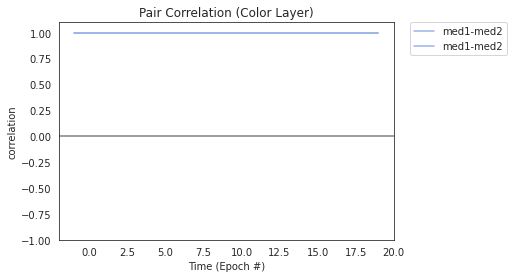

In [48]:
plt.clf()
analyses_df = plot_correlation_over_time(output_corr_long, 'Color', 'TestColorAll', numPairs, analyses_df)




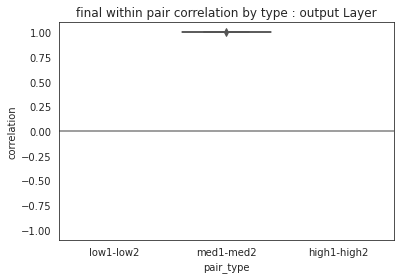

/usr/people/qanguyen/anaconda3/envs/leabra/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 66.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


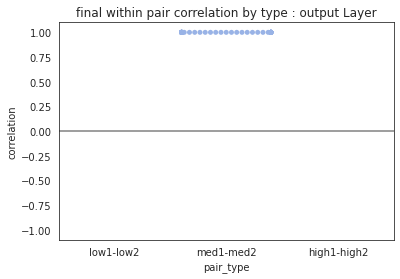

In [49]:
plt.clf()
output_just_main_corr, analyses_df = plot_final_correlation_over_time(output_corr_long, 'output', analyses_df) 

/usr/people/qanguyen/anaconda3/envs/leabra/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 432x288 with 0 Axes>

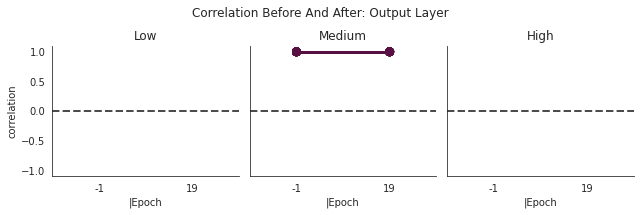

/usr/people/qanguyen/anaconda3/envs/leabra/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


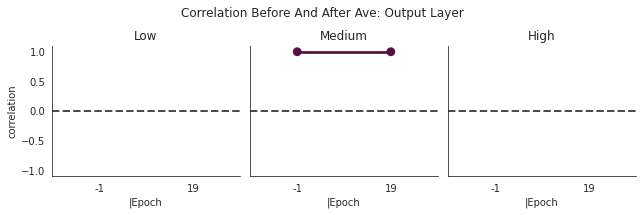

In [50]:
plt.clf()
output_just_main_corr, analyses_df = plot_correlation_comparison(output_corr_long, 'output', analyses_df) 


In [51]:
## Use try except block to not break the script if there's an error
## This is useful for the Post_analyses.py where sometimes we run test parameter searches 

title = "is the low/med/high within pair correlation in the right order in the output layer?"
try:

    print('-------------------')
    
    if study_task_run == 1 :
        aov_table = sm.stats.anova_lm(mod, typ=2)

        mod, group_diff, group_order = analyze_within_pair_correlation(output_just_main_corr)

        ## is the model significant? i.e. is low / med / high different?
        temp = ['Output w_corr difference', group_diff, 0, 'Output within pair correlation-- is there a difference between low/med/high']
        temp_series = pd.Series(temp, index = results_df.columns)
        results_df = results_df.append(temp_series, ignore_index = True)



        ## is the low/med/high within pair correlation in the right order?
        temp = ['Output w_corr order', group_order, 0, 'Output within pair correlation-- is low/med/high in the right order']
        temp_series = pd.Series(temp, index = results_df.columns)
        results_df = results_df.append(temp_series, ignore_index = True)

        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
except:
    traceback.print_exc()
    
    
    
    analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 

-------------------


### Hidden Layer: Is the low/med/high within pair correlation in the right order in the color layer?
<a id='is_the_low/med/high_within_pair_correlation_in_the_right_order_in_the_hidden_layer?'></a>

In [52]:
hidden_corr_long = make_corr_long(hiddenData, 'Hidden', 'TestColorAll', numPairs)

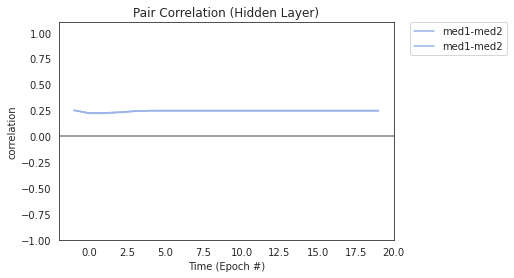

In [53]:
plt.clf()

analyses_df = plot_correlation_over_time(hidden_corr_long, 'Hidden', 'TestColorAll', numPairs, analyses_df)


In [54]:
# hidden_corr_long = plot_correlation_over_time(hiddenData, 'Hidden', 'TestSceneAll', numPairs)


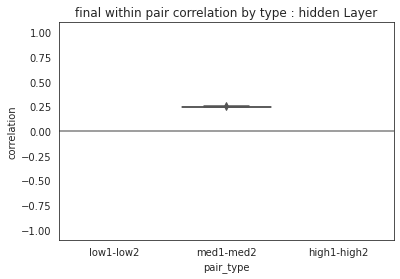

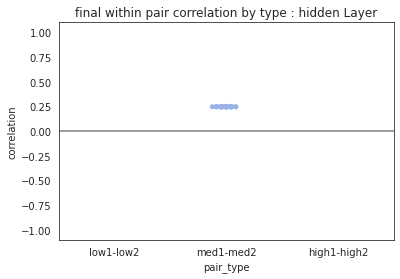

In [55]:
plt.clf()
hidden_just_main_corr, analyses_df = plot_final_correlation_over_time(hidden_corr_long, 'hidden', analyses_df) 

In [56]:
## Use try except block to not break the script if there's an error
## This is useful for the Post_analyses.py where sometimes we run test parameter searches 
title = "is the low/med/high within pair correlation in the right order in the hidden layer?"
try:

    if study_task_run == 1:
        mod, group_diff, group_order = analyze_within_pair_correlation(hidden_just_main_corr)


        ## is the model significant? i.e. is low / med / high different?
        temp = ['Hidden w_corr difference', group_diff, 0, 'Hidden within pair correlation-- is there a difference between low/med/high']
        temp_series = pd.Series(temp, index = results_df.columns)
        results_df = results_df.append(temp_series, ignore_index = True)

        ## is the low/med/high within pair correlation in the right order?
        temp = ['Hidden w_corr order', group_order, 0, 'Hidden within pair correlation-- is low/med/high in the right order']
        temp_series = pd.Series(temp, index = results_df.columns)
        results_df = results_df.append(temp_series, ignore_index = True)

        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
except:
    traceback.print_exc()
    analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 

/usr/people/qanguyen/anaconda3/envs/leabra/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 432x288 with 0 Axes>

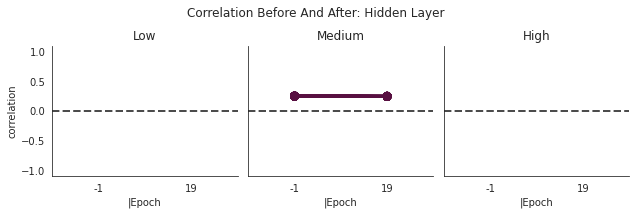

/usr/people/qanguyen/anaconda3/envs/leabra/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


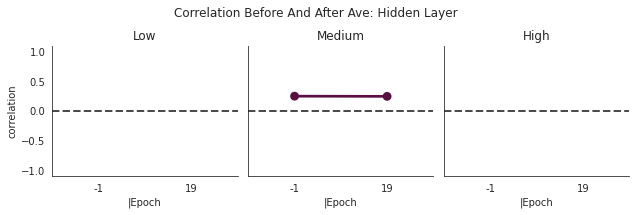

In [57]:
plt.clf()
hidden_just_main_corr, analyses_df = plot_correlation_comparison(hidden_corr_long, 'hidden', analyses_df) 

In [58]:
output_corr_long

,|Run,|Epoch,$CurrentTask,$CurrentTest,firstItem,secondItem,correlation,pair,pair_type
0,0,-1,TaskColorWOOsc,TestColorAll,med1,med1,1.0,med1-med1,identity
1,0,-1,TaskColorWOOsc,TestColorAll,med1,med2,1.0,med1-med2,med1-med2
2,0,-1,TaskColorWOOsc,TestColorAll,med2,med1,1.0,med2-med1,redundant
3,0,-1,TaskColorWOOsc,TestColorAll,med2,med2,1.0,med2-med2,identity
4,0,0,TaskColorRecall,TestColorAll,med1,med1,1.0,med1-med1,identity
...,...,...,...,...,...,...,...,...,...
4195,49,18,TaskColorRecall,TestColorAll,med2,med2,1.0,med2-med2,identity
4196,49,19,TaskColorRecall,TestColorAll,med1,med1,1.0,med1-med1,identity
4197,49,19,TaskColorRecall,TestColorAll,med1,med2,1.0,med1-med2,med1-med2
4198,49,19,TaskColorRecall,TestColorAll,med2,med1,1.0,med2-med1,redundant


# Before vs after correlation
<a id='before_vs_after_correlation'></a>

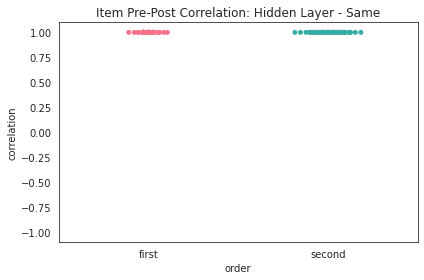

In [59]:


def plot_pre_post_correlation(data, layer):
    plt.clf()
    data=data.reset_index()


    ## get first and last epochs
    first_epoch = data['|Epoch'].min()
    last_epoch = data['|Epoch'].max()

    ## Reorganize the data frame
    data = data[data['|Epoch'].isin([first_epoch, last_epoch])]
    data = data.drop(columns = ['$CurrentTask', 'high1', 'high2', 'low1', 'low2'])
    data = data.melt(var_name='Trial', value_name='actM', value_vars=['med1', 'med2'], id_vars=['|Run', '|Epoch', '$CurrentTest', 'key'] )
    data = data.pivot(index=['|Run', '$CurrentTest', 'key', 'Trial'], columns = '|Epoch', values='actM').reset_index()
    data = data.sort_values(['|Run', '$CurrentTest', 'Trial', 'key'])

    ## Get the correlation values:
    data.head(30)
    df_pre_post_corr = data.groupby(['|Run', '$CurrentTest','Trial']).corr().reset_index()

    ## Reorganize the dataframe again:
    df_pre_post_corr = df_pre_post_corr.rename(columns={'|Epoch':'pre_post1'})
    df_pre_post_corr = df_pre_post_corr.melt(id_vars = ['|Run', '$CurrentTest', 'Trial', 'pre_post1'], var_name='pre_post2', value_vars=[first_epoch, last_epoch], value_name='correlation')

    ## We only care about correlation pre vs post:
    df_pre_post_corr = df_pre_post_corr[(df_pre_post_corr['pre_post1'] == first_epoch) & (df_pre_post_corr['pre_post2'] == last_epoch)]

    ## get the order (which trial came first or second)
    df_pre_post_corr = pd.merge(data_train_order, df_pre_post_corr, left_on = ['|Run', '$TrialName'], right_on = ['|Run', 'Trial'])

    ## add the trial type
    df_pre_post_corr['same_diff_condition'] = parameter_values['overlap']['same_diff_condition']

    ## Plot
    sns.swarmplot(x = 'order', y = 'correlation', data = df_pre_post_corr)
    plt.ylim(-1.1,1.1)
    title = 'Item Pre-Post Correlation: ' + layer.capitalize() + ' Layer - ' + parameter_values['overlap']['same_diff_condition']
    plt.title(title)
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()
    
    return df_pre_post_corr


df_pre_post_corr = plot_pre_post_correlation(hiddenData, 'hidden')



In [60]:
parameter_values['overlap']['same_diff_condition']

'Same'


# MDS
<a id='MDS'></a>

In [61]:

def find_order_data_test(row, data_train_order) :

    curr_stim = row['$TrialName']
    curr_run = row['|Run']

    order = data_train_order[(data_train_order['|Run'] == curr_run) & (data_train_order['$TrialName'] == curr_stim)]['order']   

    order = order.iloc[0]
    return order


def prepare_MDS_data(data) :
    
    run = 0
    
    col = ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', '$TrialName']
    col.extend(filter_HiddM)

#     color_task = data['$CurrentTask'] == 'TaskColorRecall'
    color_test = data['$CurrentTest'] == 'TestColorAll'



    select_data = data[color_test][col]
    select_data= select_data[select_data['$TrialName'].isin(['med1', 'med2'])]
    select_data['order'] = select_data.apply(lambda row : find_order_data_test(row, data_train_order), axis = 1)

    

    
    all_data = np.empty([0, 50])
    all_runs = np.empty([0])
    all_names = np.empty([0])
    all_trialnames = np.empty([0])
    for run in range(nruns + 1):

        run_data = select_data[select_data['|Run'] == run]
        pre = run_data['|Epoch'] == run_data['|Epoch'].min()
        post = run_data['|Epoch'] == run_data['|Epoch'].max()
        first = run_data['order'] == 'first'
        second = run_data['order'] == 'second'
        
        
        first_pre = run_data[first & pre][filter_HiddM].to_numpy()
        first_post = run_data[first & post][filter_HiddM].to_numpy()

        second_pre = run_data[second & pre][filter_HiddM].to_numpy()
        second_post = run_data[second & post][filter_HiddM].to_numpy()

        run_array = np.array([first_pre[0], first_post[0], second_pre[0], second_post[0]])


        
        all_data = np.append(all_data, run_array,0)
    
        all_runs = np.append(all_runs, np.repeat(np.round(run), 4))
        all_names = np.append(all_names, ['first_pre','first_post', 'second_pre', 'second_post'])
    
    
    
    

    
        all_trialnames = np.append(all_trialnames, 
                                   np.concatenate([np.tile(run_data[first & pre]['$TrialName'].iloc[0],2),
                                   np.tile(run_data[second & pre]['$TrialName'].iloc[0],2)]))
    
    
    
        MDS_data = {'data' : all_data, 'runs': all_runs, 'names': all_names, 'trial_names': all_trialnames}
        

    if MDS_data['data'].shape[0] != MDS_data['runs'].shape[0] or MDS_data['data'].shape[0] != MDS_data['names'].shape[0]:
        raise ValueError
        print('Something wrong with the dimensions here')
    return MDS_data

MDS_data = prepare_MDS_data(data_test)



running MDS analysis


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<Figure size 432x288 with 0 Axes>

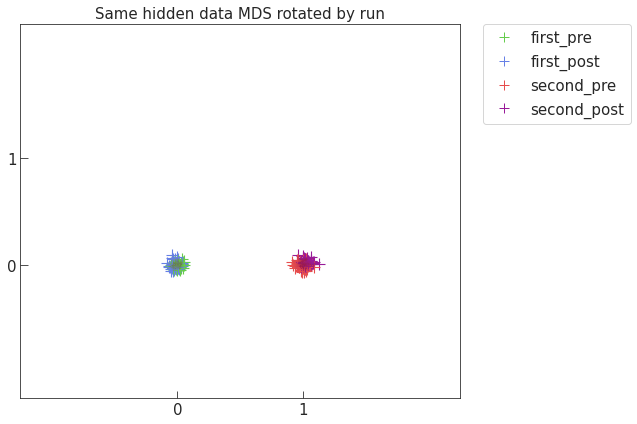

In [62]:
print("running MDS analysis", flush=True)
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.collections as mcoll

def multicolored_lines():
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    """

    x = np.linspace(0, 4. * np.pi, 100)
    y = np.sin(x)
    fig, ax = plt.subplots()
    lc = colorline(x, y, cmap='hsv')
    plt.colorbar(lc)
    plt.xlim(x.min(), x.max())
    plt.ylim(-1.0, 1.0)
    plt.show()

def colorline(ax,
        x, y, z=None, cmap='copper', norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def MDS_plot_procrustes(MDS_data, run, distance_func="euclidean") :
    def euclidean(x,y):
        return np.linalg.norm(x-y)
    def pearsoncorr(x,y):
        return stats.stats.pearsonr(x, y)[0]
    if distance_func == "euclidean":
        distance_metric = euclidean
    else:
        distance_metric = pearsoncorr
        
    def show_activation(data):
        plt.clf()
        plt.imshow(data, cmap='plasma')
        plt.show()
    
    def show_distance_matrices_activation_embds(data, embds):
        plt.clf()
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))
        run_distances = np.zeros((4, 4))
        for i in range(4):
            for j in range(4):
                run_distances[i, j] = distance_metric(data[i],data[j])
        ax0.imshow(run_distances, cmap='plasma')
        # We want to show all ticks...
        ax0.set_xticks(np.arange(4))
        ax0.set_yticks(np.arange(4))
        ax0.set_xticklabels(labels)
        ax0.set_yticklabels(labels)
        # Rotate the tick labels and set their alignment.
        plt.setp(ax0.get_xticklabels(), rotation=90, ha="right",
                     rotation_mode="anchor")
        for i in range(4):
            for j in range(4):
                text = ax0.text(j, i, "%.2f" %(run_distances[i, j]),
                               ha="center", va="center", color="gray")

        run_distances_copy = np.zeros((4, 4))
        for i in range(4):
            for j in range(4):
                run_distances_copy[i, j] = distance_metric(embds[i],embds[j])
        
        ax1.imshow(run_distances_copy, cmap='plasma')
        # We want to show all ticks...
        ax1.set_xticks(np.arange(4))
        ax1.set_yticks(np.arange(4))
        ax1.set_xticklabels(labels)
        ax1.set_yticklabels(labels)
        # Rotate the tick labels and set their alignment.
        plt.setp(ax1.get_xticklabels(), rotation=90, ha="right",
                     rotation_mode="anchor")
        for i in range(4):
            for j in range(4):
                text = ax1.text(j, i, "%.2f" %(run_distances[i, j]),
                               ha="center", va="center", color="gray")
                
        plt.show()
        
    def show_scatter_pre_post_transform(pre, post, names):
        plt.clf()
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))
        ax0.scatter(pre[:,0], pre[:,1], c = [color_dict[name] for name in names], 
                alpha = .9)
        ax1.scatter(post[:,0], post[:,1], c = [color_dict[name] for name in names], 
                alpha = .9)
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.show()
    
    def get_polar_angle(x, y):
        return np.arctan2(y, x) 
    
    def procrustes(data1):
        mtx1 = data1

        if mtx1.ndim != 2:
            raise ValueError("Input matrices must be two-dimensional")
        if mtx1.size == 0:
            raise ValueError("Input matrices must be >0 rows and >0 cols")
            
        # translate all the data to the origin
        
        translate = mtx1[[0]]
        temp = mtx1 - mtx1[[0]]
        theta = get_polar_angle(temp[1, 0], temp[1, 1])
        rotation_matrix = np.array([[np.cos(-theta), -np.sin(-theta)],
                                    [np.sin(-theta), np.cos(-theta)]])
        scale = np.linalg.norm(temp[1])
        
        
        return translate, rotation_matrix, scale
    color_dict = {'first_pre': [.4, .8, .3], 'first_post': [.4, .5, .9],
                  'second_pre': [.9, .3, .3], 'second_post': [.6, .1, .6],
                  'mean_first': [.4, .65, .6], 'mean_second': [.75, .2, .45]
                 }
        

    data = MDS_data['data']
    names = MDS_data['names']
    labels = ['first_pre', 'first_post', 'second_pre', 'second_post']
    
    
    plt.clf()
    fig, ax = plt.subplots(figsize=(9, 6))
    embedding = MDS(n_components = 2)
    data = np.roll(MDS_data["data"], -1, axis=-1)
    # Flip embeddings across midline if trial starts with med2
    for run in range(nruns+1):
        if MDS_data["trial_names"][4 * run] == "med2":
            data[4 * run:4 * run+4] = np.fliplr(data[4 * run:4 * run+4])
    X_transformed = embedding.fit_transform(data)
    translate = X_transformed[[0]]
    X_transformed -= translate
    theta = get_polar_angle(X_transformed[2, 0], X_transformed[2, 1])
    rotation_matrix = np.array([[np.cos(-theta), -np.sin(-theta)],
                                [np.sin(-theta), np.cos(-theta)]])

    scale = np.linalg.norm(X_transformed[2])
    X_transformed =1/scale* (rotation_matrix@X_transformed.T).T + np.random.randn(*X_transformed.shape)*0.03
    
    # Flip across y-axis if most second-post points are below y-axis
    if np.mean(X_transformed[3::4, 1] > 0) < 0.5:
        X_transformed *= np.array([[1, -1]])
            
    scatter = ax.scatter(X_transformed[:,0], X_transformed[:,1], 
                         c = [color_dict[name] for name in names], 
            alpha = 1.0, marker='+', s=150,zorder=2, linewidths=1.10)
    
    
    for run in range(nruns+1):
        cm = LinearSegmentedColormap.from_list(
        "Custom", [color_dict['first_pre'], color_dict['first_post']], N=20)
        x = np.linspace(X_transformed[4*run+0,0],X_transformed[4*run+1,0],100)
        y = np.linspace(X_transformed[4*run+0,1],X_transformed[4*run+1,1],100)
        lc = colorline(ax, x, y, cmap=cm, alpha=0.1)

        cm = LinearSegmentedColormap.from_list(
        "Custom", [color_dict['second_pre'], color_dict['second_post']], N=20)
        x = np.linspace(X_transformed[4*run+2,0],X_transformed[4*run+3,0],100)
        y = np.linspace(X_transformed[4*run+2,1],X_transformed[4*run+3,1],100)
        lc = colorline(ax, x, y, cmap=cm, alpha=0.1)
        
    #plt.axis('square')
    
    legend_elements = [
                   Line2D([0], [0], marker='+', color=color_dict['first_pre'], label='first_pre',
                          markersize=10, lw = 0),
                    Line2D([0], [0], marker='+', color=color_dict['first_post'], label='first_post',
                                      markersize=10, lw = 0),
                    Line2D([0], [0], marker='+', color=color_dict['second_pre'], label='second_pre',
                                      markersize=10, lw = 0),
                    Line2D([0], [0], marker='+', color=color_dict['second_post'], label='second_post',
                                      markersize=10, lw = 0)
    ]

    ax.legend(handles = legend_elements, bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad=0., fontsize=15)
    title = parameter_values['overlap']['same_diff_condition'] + ' hidden data MDS rotated by run'
    ax.set_title(title)
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

    
    
    plt.xlim(-1.25, 2.25)
    plt.ylim(-1.25, 2.25)
    plt.xticks([0,1])
    plt.yticks([0,1])
    plt.tick_params(length=7.5, bottom=True, left=True, direction="in")
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    plt.savefig(eps_dir + title + '.eps')

    plt.show()
    
# MDS_plot(MDS_data, 0)
transformed_X_list = MDS_plot_procrustes(MDS_data, 'all')



### Probability each unit

# CENTER OF MASS 
<a id='CENTER_OF_MASS'></a>

In [63]:
def calc_center_of_mass(act_array):
    unit_num = np.arange(1,51)

    weighted = unit_num * act_array
    weighted_sum = weighted.sum()
    mass_sum = act_array.sum() + 1e-30
    center_temp = weighted_sum / mass_sum
    
    return center_temp

In [64]:
def calc_coa_true() :
    numTotalUnits = parameter_values['overlap']['numTotalUnits']
    numOverlapUnits = parameter_values['overlap']['numOverlapUnits'] 

    print("Warning: Assuming med2 output representation starts at index 25")
    unique = numTotalUnits - numOverlapUnits
    true_val_dict = {}
    
    if parameter_values['overlap']['same_diff_condition'] == 'Different':

        true_val_dict['med1'] = 26
        true_val_dict['med2'] = 30
    
    elif parameter_values['overlap']['same_diff_condition'] == 'Same':
        true_val_dict['med1'] = 26
        true_val_dict['med2'] = 26
    
    return true_val_dict

true_val_dict = calc_coa_true()

In [65]:


def find_center_of_mass(data, epoch, trial, run, layer) :
#     center_of_mass = np.empty(0)
#     for run in range(data_train['|Run'].max()):
    
    if_curr_run = data_test['|Run'] == run
    if_baseline_epoch = data_test['|Epoch'] == epoch
    if_trial = data_test['$TrialName'] == trial

    if layer == 'output':
        col_str = '#OutActM[' 
    elif layer == 'hidden' :
        col_str = '#HiddenActM['
        

    layer_col = [col for col in data.columns if col.startswith(col_str)]
    
#     if layer == 'output' :
#         layer_col = [col for col in data.columns if col.startswith('#OutActM[')]
#     elif layer == 'hidden' :
#         layer_col = [col for col in data.columns if col.startswith('#HiddenActM[')]

    curr = data_test[if_curr_run & if_baseline_epoch & if_trial][layer_col].reset_index(drop = True)

    curr_np = curr.iloc[[0]].to_numpy()
    
    center_temp = calc_center_of_mass(curr_np)
#     print(curr_np)
    

# #     plt.imshow(curr)
# #     plt.show()

#     unit_num = np.arange(1,51)


#     weighted = unit_num * curr_np
#     weighted_sum = weighted.sum()
#     mass_sum = curr_np.sum()
#     center_temp = weighted_sum / mass_sum
    return center_temp
#     center_of_mass = np.append(center_of_mass, center_temp)
#     return center_of_mass
    

In [66]:

def get_center_mass_df(data, layer) :
    center_of_mass_df = pd.DataFrame(columns = ['run', 'time', 'type','stim', 'layer', 'c_o_m'])

    for run in range(data_train['|Run'].max()) :
        for time in ['pre', 'post'] :
            if time == 'pre' :
                epoch = epoch_end_initial

            elif time == 'post' :
                epoch = max_final_epoch

            for item in ['low1', 'low2', 'med1', 'med2', 'high1', 'high2']:
    #     for item in ['pre_low1', 'pre_low2', 'pre_med1', 'pre_med2' ,'pre_high1', 'pre_high2'] :
    #         itemName = item[4:]

                c_o_a = find_center_of_mass(data, epoch, item, run, layer = layer)
                temp = [run, time, 'raw', item, layer, c_o_a]
                temp_series = pd.Series(temp, index = center_of_mass_df.columns)
                center_of_mass_df = center_of_mass_df.append(temp_series, ignore_index = True)


    return center_of_mass_df


In [67]:

is_output_test = data_test['$CurrentTest'] == 'TestColorAll'
is_output_recall = data_test['$CurrentTask'] == 'TaskColorRecall'

curr_data_test = data_test[is_output_test & is_output_recall]



output_center_of_mass_df = get_center_mass_df(curr_data_test, 'output')
hidden_center_of_mass_df = get_center_mass_df(curr_data_test, 'hidden')

### compare to true center of mass
This can't be done with the hidden layer, since there isn't really a "true" center of mass.

In [68]:
def flip_error(row, true_val_dict):
    
    curr_stim = row['stim']
    
    if curr_stim[-1] == '1' :
        other_stim_n = '2'
    elif curr_stim[-1] == '2' :
        other_stim_n = '1'
        
    other_stim = curr_stim[:-1] + other_stim_n
    
    dist_size = true_val_dict[other_stim] - true_val_dict[curr_stim]

    ### NOTE: THIS ONLY WORKS RIGHT NOW DIST SIZE IS LESS THAN 180
    if dist_size < 0 :
        rev_error = -1 * row['raw_error']
    else :
        rev_error = row['raw_error']

    
    return rev_error 


In [69]:
true_val_dict

{'med1': 26, 'med2': 26}

In [70]:
def calc_error(c_o_a_df_output, true_val_dict) :
    
    c_o_a_df_color =c_o_a_df_output.dropna()

    c_o_a_df_output['true_c_o_m'] = c_o_a_df_output['stim'].map(true_val_dict)
    
    print(c_o_a_df_output)

    c_o_a_df_output['raw_error'] = round(c_o_a_df_output['c_o_m'] - c_o_a_df_output['true_c_o_m'], 5)
    
    c_o_a_df_output['rev_error'] = c_o_a_df_output.apply(lambda row: flip_error(row, true_val_dict), axis=1)
    

    return c_o_a_df_output
    
    ## This is where we'd run 

In [71]:
output_center_of_mass_df = output_center_of_mass_df[output_center_of_mass_df['stim'].isin(['med1','med2'])]
output_center_of_mass_df = calc_error(output_center_of_mass_df, true_val_dict) 

    run  time type  stim   layer  c_o_m  true_c_o_m
2     0   pre  raw  med1  output   26.0          26
3     0   pre  raw  med2  output   26.0          26
8     0  post  raw  med1  output   26.0          26
9     0  post  raw  med2  output   26.0          26
14    1   pre  raw  med1  output   26.0          26
..   ..   ...  ...   ...     ...    ...         ...
573  47  post  raw  med2  output   26.0          26
578  48   pre  raw  med1  output   26.0          26
579  48   pre  raw  med2  output   26.0          26
584  48  post  raw  med1  output   26.0          26
585  48  post  raw  med2  output   26.0          26

[196 rows x 7 columns]


In [72]:
hidden_center_of_mass_df = hidden_center_of_mass_df[hidden_center_of_mass_df['stim'].isin(['med1','med2'])]


In [73]:
output_center_of_mass_df

,run,time,type,stim,layer,c_o_m,true_c_o_m,raw_error,rev_error
2,0,pre,raw,med1,output,26.0,26,0.0,0.0
3,0,pre,raw,med2,output,26.0,26,-0.0,-0.0
8,0,post,raw,med1,output,26.0,26,0.0,0.0
9,0,post,raw,med2,output,26.0,26,0.0,0.0
14,1,pre,raw,med1,output,26.0,26,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...
573,47,post,raw,med2,output,26.0,26,0.0,0.0
578,48,pre,raw,med1,output,26.0,26,0.0,0.0
579,48,pre,raw,med2,output,26.0,26,0.0,0.0
584,48,post,raw,med1,output,26.0,26,0.0,0.0


#### Order effects

In [74]:
output_center_of_mass_df.head()

,run,time,type,stim,layer,c_o_m,true_c_o_m,raw_error,rev_error
2,0,pre,raw,med1,output,26.0,26,0.0,0.0
3,0,pre,raw,med2,output,26.0,26,-0.0,-0.0
8,0,post,raw,med1,output,26.0,26,0.0,0.0
9,0,post,raw,med2,output,26.0,26,0.0,0.0
14,1,pre,raw,med1,output,26.0,26,-0.0,-0.0


In [75]:
hidden_center_of_mass_df.head()

,run,time,type,stim,layer,c_o_m
2,0,pre,raw,med1,hidden,24.525504
3,0,pre,raw,med2,hidden,28.483795
8,0,post,raw,med1,hidden,24.519899
9,0,post,raw,med2,hidden,28.485309
14,1,pre,raw,med1,hidden,24.510230


In [76]:
# output_center_of_mass_df[(output_center_of_mass_df['stim'].isin(['med1','med2'])) & (output_center_of_mass_df['run']==1)]

def find_order(row, data_train_order) :
    plt.clf()

    curr_stim = row['stim']
    curr_run = row['run']
    order = data_train_order[(data_train_order['|Run'] == curr_run) & (data_train_order['$TrialName'] == curr_stim)]['order']   
    order = order.iloc[0]
    return order

output_center_of_mass_df['order'] = output_center_of_mass_df.apply(lambda row : find_order(row, data_train_order), axis = 1)
hidden_center_of_mass_df['order'] = hidden_center_of_mass_df.apply(lambda row : find_order(row, data_train_order), axis = 1)




<Figure size 432x288 with 0 Axes>

#### Plot distance center of mass - can be done for both color and hidden

In [77]:
def calc_c_o_a_distance(center_of_mass_df, layer) :
    for run in range(data_train['|Run'].max()) :
        for time in ['pre', 'post'] :
            pair = 'med' #this is only for med right now
            is_run = center_of_mass_df['run']==run
            is_time = center_of_mass_df['time']== time

            item1 = pair + '1'
            item2 = pair + '2'

            val2 = center_of_mass_df[is_run & is_time  & (center_of_mass_df['stim'] == item2)][['c_o_m']].to_numpy()
            val1 = center_of_mass_df[is_run & is_time  & (center_of_mass_df['stim'] == item1)][['c_o_m']].to_numpy()

            diff = val2 - val1
            diff = diff[0][0]
            name = pair + '_diff'
            
            if layer != 'hidden' :
                temp = [run, time, 'diff', name, layer, diff, np.nan, np.nan, np.nan, np.nan]

            elif layer == 'hidden' :
                temp = [run, time, 'diff', name, layer, diff, np.nan]

            temp_series = pd.Series(temp, index = center_of_mass_df.columns)

            center_of_mass_df = center_of_mass_df.append(temp_series, ignore_index = True)# for item in ['post_low1', 'post_low2', 'post_med1', 'post_med2' ,'post_high1', 'post_high2'] :

    return center_of_mass_df


In [78]:
def plot_center_of_mass_dist(center_of_mass_df, layer) :
    ## Use try except block to not break the script if there's an error
    ## This is useful for the Post_analyses.py where sometimes we run test parameter searches 
    title = 'Distance Between Center of Masses: ' + layer 
    
    try:
        plt.clf()
#         temp = center_of_mass_df[center_of_mass_df['stim'].isin(['med_diff'])]

#         print(temp.head())
        if study_task_run == 1 :
            ax = sns.violinplot(x="stim", y="c_o_m", hue="time", data=center_of_mass_df, dodge=True)
        elif study_task_run ==0 :
            ax = sns.swarmplot(x = "stim", y="c_o_m", hue="time", data=center_of_mass_df, alpha = .2)

        ax = sns.pointplot(x = "stim", y="c_o_m", hue="time", data=center_of_mass_df, legend = False)
        # sns.swarmplot(x="key", y="value", hue="time", data=temp, color ='white', dodge=True)

        handles, labels = ax.get_legend_handles_labels()
        l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        plt.ylim(0,12)
        plt.ylabel('units apart')
        plt.title(title)
        plt.savefig(results_fig_dir + title + '.png')

        plt.show()

        print('this is assuming just medium overlap condition:')
        units_apart = center_of_mass_df.dropna()
        units_apart[units_apart['time'] == 'post']
#         tstat, pvalue = stats.ttest_1samp(units_apart[units_apart['time'] == 'post']['c_o_m'], 4)
#         print('is post-difference significantly different from 4 (pre training unit apart distance)?')
#         print('t = ' + str(tstat))
#         print('p = ' + str(pvalue))

#         print('pre: ' + str(units_apart[units_apart['time'] == 'pre'].c_o_m.mean()))
#         print('post: ' + str(units_apart[units_apart['time'] == 'post'].c_o_m.mean()))


#         if study_task_run == 1:
#             model = ols('c_o_m ~ C(time)*C(stim)', temp).fit()
#             print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
#             print('----')
#             print('MODEL SUMMARY: ')
#             print(model.summary())
#             print('----')
#             res = sm.stats.anova_lm(model, typ= 2)
#             print(res)

#             analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 

    except:
        traceback.print_exc()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 

In [79]:
hidden_center_of_mass_df = calc_c_o_a_distance(hidden_center_of_mass_df, 'hidden')
hidden_distance_df = hidden_center_of_mass_df[hidden_center_of_mass_df['stim'].isin(['med_diff'])]
hidden_distance_df

,run,time,type,stim,layer,c_o_m,order
196,0,pre,diff,med_diff,hidden,3.958291,NaN
197,0,post,diff,med_diff,hidden,3.965410,NaN
198,1,pre,diff,med_diff,hidden,3.964839,NaN
199,1,post,diff,med_diff,hidden,3.969518,NaN
200,2,pre,diff,med_diff,hidden,3.965695,NaN
...,...,...,...,...,...,...,...
289,46,post,diff,med_diff,hidden,3.977029,NaN
290,47,pre,diff,med_diff,hidden,3.961597,NaN
291,47,post,diff,med_diff,hidden,3.977486,NaN
292,48,pre,diff,med_diff,hidden,3.965521,NaN


In [80]:
output_center_of_mass_df

,run,time,type,stim,layer,c_o_m,true_c_o_m,raw_error,rev_error,order
2,0,pre,raw,med1,output,26.0,26,0.0,0.0,second
3,0,pre,raw,med2,output,26.0,26,-0.0,-0.0,first
8,0,post,raw,med1,output,26.0,26,0.0,0.0,second
9,0,post,raw,med2,output,26.0,26,0.0,0.0,first
14,1,pre,raw,med1,output,26.0,26,-0.0,-0.0,first
...,...,...,...,...,...,...,...,...,...,...
573,47,post,raw,med2,output,26.0,26,0.0,0.0,first
578,48,pre,raw,med1,output,26.0,26,0.0,0.0,first
579,48,pre,raw,med2,output,26.0,26,0.0,0.0,second
584,48,post,raw,med1,output,26.0,26,0.0,0.0,first


In [81]:
output_center_of_mass_df = calc_c_o_a_distance(output_center_of_mass_df, 'layer')
output_distance_df = output_center_of_mass_df[output_center_of_mass_df['stim'].isin(['med_diff'])]

In [82]:
def join_center_of_mass_DFs(output_c_m_DF, hidden_c_m_DF) :
    
    output_c_m_DF['layer'] = 'output'
    hidden_c_m_DF['layer'] = 'hidden'

    new_df = output_c_m_DF.append(hidden_c_m_DF)
    
    new_df['overlap'] = parameter_values['overlap']['overlapType']
    return new_df

center_of_mass_df = join_center_of_mass_DFs(output_center_of_mass_df,hidden_center_of_mass_df)


In [83]:
hidden_corr_long

,|Run,|Epoch,$CurrentTask,$CurrentTest,firstItem,secondItem,correlation,pair,pair_type
0,0,-1,TaskColorWOOsc,TestColorAll,med1,med1,1.000000,med1-med1,identity
1,0,-1,TaskColorWOOsc,TestColorAll,med1,med2,0.251133,med1-med2,med1-med2
2,0,-1,TaskColorWOOsc,TestColorAll,med2,med1,0.251133,med2-med1,redundant
3,0,-1,TaskColorWOOsc,TestColorAll,med2,med2,1.000000,med2-med2,identity
4,0,0,TaskColorRecall,TestColorAll,med1,med1,1.000000,med1-med1,identity
...,...,...,...,...,...,...,...,...,...
4195,49,18,TaskColorRecall,TestColorAll,med2,med2,1.000000,med2-med2,identity
4196,49,19,TaskColorRecall,TestColorAll,med1,med1,1.000000,med1-med1,identity
4197,49,19,TaskColorRecall,TestColorAll,med1,med2,0.248913,med1-med2,med1-med2
4198,49,19,TaskColorRecall,TestColorAll,med2,med1,0.248913,med2-med1,redundant


# Plot # Shared units in hidden layer



In [84]:
curr_data = data_test

is_med = curr_data['$TrialName'].isin(['med1','med2'])
curr_data = curr_data[is_med]
hidden_cols = [col for col in curr_data if col.startswith('#HiddenActM[')]

column_names = ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', '$TrialName']
column_names_all = column_names + hidden_cols


curr_data = curr_data[column_names_all]

curr_data = curr_data.melt(id_vars=column_names, var_name='Unit_Name', value_name='act')
curr_data['act_bool'] = np.where(curr_data['act']> 0.1, 1,0)
curr_data = curr_data.sort_values(column_names)


curr_data_piv = curr_data.pivot(index = ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', 'Unit_Name'], columns='$TrialName', values='act_bool').reset_index()

curr_data_piv['shared'] = np.where((curr_data_piv['med1'] == 1) & (curr_data_piv['med2'] == 1), 1, 0)
shared_total = curr_data_piv.groupby(['|Run', '|Epoch'])['shared'].sum()
shared_total = shared_total.reset_index()
total_act = curr_data.groupby(['|Run', '|Epoch', '$TrialName'])['act_bool'].sum().reset_index()
total_act = total_act.pivot(index = ['|Run', '|Epoch'], columns='$TrialName', values='act_bool').reset_index()

num_shared_units_df = pd.merge(shared_total, total_act, on = ['|Run', '|Epoch'])
num_shared_units_melt_df = num_shared_units_df.melt(id_vars=['|Run', '|Epoch'], var_name='type', value_name='num_units')

# put in the correct order:
num_shared_units_melt_df = pd.merge(num_shared_units_melt_df, data_train_order, how = 'left',left_on = ['|Run', 'type'], right_on = ['|Run', '$TrialName'])
num_shared_units_melt_df['order'].fillna(num_shared_units_melt_df['type'], inplace = True)
num_shared_units_melt_df = num_shared_units_melt_df.drop(columns = '$TrialName')
num_shared_units_melt_df = num_shared_units_melt_df.rename(columns = {'type': '$TrialName', 'order': 'type'})


num_shared_units_df['same_diff_condition'] = parameter_values['overlap']['same_diff_condition']

## Add necessary checkpoint info
<a id='Add_necessary_checkpoint_info'></a>

In [85]:
checkpoints_df['OscAmnt_Scene'] = parameter_values['OscAmnt']['Scene']
checkpoints_df['Gi_Scene'] = parameter_values['Gi']['Scene']
checkpoints_df['OscAmnt_Hidd'] = parameter_values['OscAmnt']['Hidden']
checkpoints_df['Gi_Hidd'] = parameter_values['Gi']['Hidden']
checkpoints_df['OscAmnt_Out'] = parameter_values['OscAmnt']['Output']
checkpoints_df['Gi_Out'] = parameter_values['Gi']['Output']
checkpoints_df['dir_name'] = data_file

checkpoints_df.to_csv(checkpoint_fig_dir + 'checkpoints.csv')

results_df['OscAmnt_Scene'] = parameter_values['OscAmnt']['Scene']
results_df['Gi_Scene'] = parameter_values['Gi']['Scene']
results_df['OscAmnt_Hidd'] = parameter_values['OscAmnt']['Hidden']
results_df['Gi_Hidd'] = parameter_values['Gi']['Hidden']
results_df['OscAmnt_Out'] = parameter_values['OscAmnt']['Output']
results_df['Gi_Out'] = parameter_values['Gi']['Output']
results_df['same_diff_condition'] = parameter_values['overlap']['same_diff_condition']
results_df['dir_name'] = data_file
results_df.to_csv(results_fig_dir + 'results.csv')


analyses_df['dir_name'] = data_file
analyses_df.to_csv(figDir + 'analyses.csv')

center_of_mass_df['same_diff_condition'] = parameter_values['overlap']['same_diff_condition']
center_of_mass_df.to_csv(results_fig_dir + 'center_of_mass.csv')




## correlation df:
hidden_corr_long['layer'] = 'hidden'
output_corr_long['layer'] = 'output'
corr_df = hidden_corr_long.append(output_corr_long)
corr_df['same_diff_condition'] = parameter_values['overlap']['same_diff_condition']
corr_df.to_csv(results_fig_dir + 'correlation.csv')

num_shared_units_df.to_csv(results_fig_dir + 'num_units.csv')
df_pre_post_corr.to_csv(results_fig_dir + 'pre_post_corr.csv')
with open(f"{dataDir}/codeprofiler.txt", "w", encoding="utf-8") as f:
    s = io.StringIO()
    ps = pstats.Stats(codeprofiler, stream=s).sort_stats("cumtime")
    ps.print_stats()
    f.write(s.getvalue())



## Save
<a id='Save'></a>

In [86]:
if from_cmdLine != 'cmd' :
    os.system('ipython nbconvert --to HTML Post_analyses.ipynb')
    os.system('mv Post_analyses.html ' + dataDir + data_file + '_analysis.html')
    print(data_file)

2022-06-09-12-41-26


In [87]:
print('done with analysis!')

done with analysis!
